In [6]:
system.time({source("paper_utils.R")})

   user  system elapsed 
  0.009   0.006   0.015 

In [7]:
cachedir <- "/data/srlab/ik936/NOTCH/data/cache/"
tissue <- readRDS(file.path(cachedir, "analysis_sc_tissue.rds"))
mouse <- readRDS(file.path(cachedir, "mouse.rds"))
joint <- readRDS(file.path(cachedir, "analysis_sc_tissue_mm.rds"))
bulk <- readRDS(file.path(cachedir, "bulk_data.rds"))

data_if <- fread("/data/srlab/ik936/NOTCH/paper/if_distances.txt") %>% 
    data.frame() %>% 
    subset(ncells_image > 1000) %>% 
    dplyr::mutate(Sample = ifelse(Sample == '183_C', 'RA183', Sample)) ## to make labels more consistent with filenames

In [8]:
nice_name <- c(pericytes = "Pericytes", lining = "Lining Fibroblasts", sublining = "Sublining Fibroblasts", 
               sublining_cd34 = "Sublining Fibroblasts", endothelial = "Blood Vessel Cells", 
               oa = "Tissue OA", ra = "Tissue RA", MM1 = "fibroblast organoid", 
               MM2 = "fibroblast + blood vessel\norganoid", Tissue = "synovial tissue", 
              endo_st = "blood vessel cells", 
                peri_st = "pericytes", 
                endo_mm = "blood vessel cells",
                peri_mm = "fibroblasts + pericytes",
               primary = "Synovial Tissue", culture = "Organoid",
               blood = "Blood vessel cells", lymph = "Lymphatic vessel cells"
)
nice_names <- data.frame(nice_name, stringsAsFactors = FALSE) %>% tibble::rownames_to_column("given_name")
nice_names_list <- nice_name
# nice_names

In [9]:
bin_95 <- function (data_df, xvar, yvars, num.bin, .include.lowest = TRUE) 
{
    data_df <- data.frame(data_df)
    x <- data_df[[xvar]]
    .breaks <- unique(quantile(x, probs = seq(0, 1, length.out = num.bin)))
    bin_means <- 0.5 * (head(.breaks, -1) + tail(.breaks, -1))
    bins_freq <- cut(x, .breaks, include.lowest = .include.lowest)
    levels(bins_freq) <- bin_means
    xmeans <- lapply(split(x, as.integer(bins_freq)), mean) %>% 
        as.numeric
    res_df <- Reduce(rbind, lapply(yvars, function(yvar) {
        y <- data_df[[yvar]]
        ymeans <- lapply(split(y, as.integer(bins_freq)), mean) %>% 
            as.numeric
        ysd <- lapply(split(y, as.integer(bins_freq)), sd) %>% 
            as.numeric
        data.frame(xval = xmeans) %>% cbind(Reduce(rbind, lapply(split(y, 
            as.integer(bins_freq)), function(.x) quantile(.x, 
            c(0.05, 0.95)))) %>% data.frame() %>% dplyr::mutate(symbol = yvar)) %>% 
            cbind(yval = ymeans, ysd = ysd)
    })) %>% data.frame()
    return(res_df)
}

# Figure 1

Populations in synovium

## 1a Donor batch effect, before and after

    scatter plots, before and after by donor

In [152]:
fig.size(4, 10)
with(tissue, {
    do_scatter(umap, meta_data, 'donor', pt_size = 4, 
                              palette_use = tableau_color_pal('Tableau 20')(12), do_labels = FALSE) + 
    labs(title = "Before Harmony correction") + 
    do_scatter(umap_harmony, meta_data, 'donor', pt_size = 4, no_guides = FALSE,
                              palette_use = tableau_color_pal('Tableau 20')(12), do_labels = FALSE) + 
    labs(title = "After Harmony correction") + 
    patchwork::plot_annotation(tag_levels = 'A') + 
    NULL    
    ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/umap_batch.pdf', device = "pdf", 
           dpi = 300, width = 10, height = 4, useDingbats = FALSE)    
})



## 1b dot plots

In [232]:
genes_use <- rev(c('PDGFRA', 'PDPN', 'PRG4', 'CD55', 'THY1', 'PDGFRB', 'ACTA2', 'MCAM', 'VWF', 'CD34'))

with(tissue, {
    cell_levels <- c('lining', 'sublining', 'pericytes', 'blood')
    gene_levels <- genes_use
    
    markers_tidy <- dplyr::inner_join(
        markers$pct_in %>% data.frame %>% tibble::rownames_to_column("symbol") %>% 
            tidyr::gather(cluster, pct, -symbol),
        markers$means %>% data.frame %>% tibble::rownames_to_column("symbol") %>% 
            tidyr::gather(cluster, avg_exp, -symbol), 
        by = c("symbol", "cluster")
    )
    X <- markers_tidy %>% 
        subset(symbol %in% gene_levels)

    X$cell_type <- X$cluster
    data_plot <- X %>%
        dplyr::mutate(symbol = factor(symbol, gene_levels)) %>%
        dplyr::mutate(pct = ifelse(is.na(pct), 0, pct)) %>% 
        dplyr::mutate(avg_exp = ifelse(is.na(avg_exp), 0, avg_exp)) %>% 
        dplyr::group_by(symbol) %>% 
        mutate(avg_exp = scale(avg_exp)) %>% 
        mutate(avg_exp_scale = MinMax(avg_exp, max = 2.5, min = -2.5)) %>%
        ungroup() %>%
        identity()
    
    fig.size(4.5, 2.7)
    data_plot %>% 
        dplyr::mutate(cell_type = factor(cell_type, cell_levels)) %>% 
        subset(!is.na(cell_type)) %>% 
        ggplot(aes(cell_type, symbol)) + 
            geom_point(aes(size = 100 * pct, color = avg_exp_scale)) + 
            scale_color_gradient2(mid = 'lightgrey', high = muted('blue'), midpoint = min(data_plot$avg_exp_scale)) + 
            scale_size_area(max_size = 4) + 
            theme(axis.title.x = element_blank(), axis.title.y = element_blank()) + 
            scale_x_discrete(labels = nice_names_list) + 
            theme_tufte() + theme(panel.background = element_rect()) + 
            theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
            labs(x = "", y = "", size = '%Cells\nExpressing', color = 'Mean\nExpression\n(scaled)') + 
            NULL    
    
    ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/dotplot_main.pdf', device = "pdf", 
           dpi = 300, width = 2.7, height = 4.5, useDingbats = FALSE)  
    
})

 

## 1c

In [7]:
fig.size(2, 5)
features <- c('PRG4', 'THY1')
with(tissue, {
    idx_use <- 1:nrow(meta_data)
    plt_list <<- lapply(features, function(feature) {
        plotFeatures(exprs_norm[, idx_use], umap_harmony[idx_use, ], order_by_expression = FALSE, no_guide = FALSE,
                     feature, nrow = 1, qlo = .02, qhi = .8)        
    })

})


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


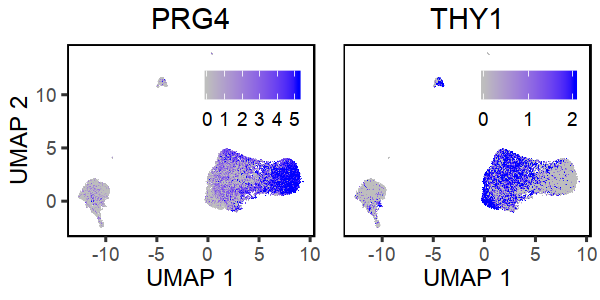

In [22]:
fig.size(2.5, 5)
(umap_markers <- plt_list[[1]] + 
    labs(color = '') + 
    theme(panel.background = element_rect(), plot.title = element_text(hjust = 0.5),
          legend.position="bottom", legend.box = "horizontal") + 
    scale_color_gradient2(
        mid = "grey", high = "blue", midpoint = 0, 
        guide = guide_colorbar(
            direction = "horizontal", title.position = "top",
            label.position = "bottom", label.hjust = 0.5, 
            label.vjust = 0.5, barwidth = 4,
        ), breaks = 0:5
    ) + 
    theme(legend.position = c(0.75, .8)) + 
plt_list[[2]] + 
#     labs(color = "Log CPM") + 
    labs(color = '') + 
    theme(panel.background = element_rect(), plot.title = element_text(hjust = 0.5),
          axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank(), 
          legend.position="bottom", legend.box = "horizontal") + 
    scale_color_gradient2(
        mid = "grey", high = "blue", midpoint = 0, 
        guide = guide_colorbar(
            direction = "horizontal", title.position = "top",
            label.position = "bottom", label.hjust = 0.5, 
            label.vjust = 0.5, barwidth = 4,
        ), breaks = 0:5
    ) + 
    theme(legend.position = c(0.75, .8)) + 
NULL)


ggsave('/data/srlab/ik936/NOTCH/paper/figure1/umap_markers.pdf', plot = umap_markers, device = "pdf", 
       dpi = 300, width = 5, height = 2.5, useDingbats = FALSE)

## 1f: Additional trajectory markers 

In [111]:
# markers <- c('NOTCH3', 'THY1', 'PRG4', 'CD55', 'GGT5', 'PDPN')
markers <- c('CD55', 'GGT5', 'PDPN')
idx_use <- which(tissue$meta_data$cell_type %in% c("lining", "sublining"))
length(idx_use)
ldata <- data.frame(
    time = tissue$meta_data[idx_use, "time"], 
#     t(as.matrix(xcor))
    t(as.matrix(tissue$exprs_norm[markers, idx_use]))
) %>% 
    bin_95("time", markers, 50)


[1] 27216

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


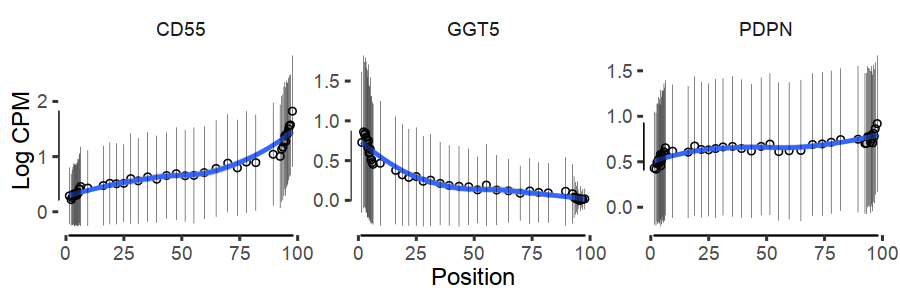

In [117]:
fig.size(2.5, 7.5)

(pseudotime_markers <- ldata %>% 
    ggplot(aes(100 - xval, yval)) + 
         geom_point(shape = 21) + 
    geom_smooth() + 
        geom_errorbar(width=0, aes(ymin=yval - ysd, ymax=yval + ysd), size = .1) +
        facet_wrap(~symbol, scales = "free_y", nrow = 1) + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + geom_rangeframe() + 
        labs(y = "Log CPM", x = "Position")
)    


ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/pseudotime_markers_extra.pdf', device = "pdf", 
       dpi = 300, width = 7.5, height = 2.5, useDingbats = FALSE)

In [151]:
tissue$axis_associated_genes %>% 
    tibble::rownames_to_column('symbol') %>% 
    subset(adj.P.Val < 1e-5) %>% head(1000) %>% 
    dplyr::arrange(t) %>% 
    dplyr::select(-B) %>% 
    dplyr::mutate(associated_with = case_when(
        t > 0 ~ 'Sublining', 
        t < 0 ~ 'Perivascular'
    )) %>% 
    dplyr::rename(log_fold_change = logFC, mean_expression = AveExpr, t_statistic = t, p_value = P.Value, adjusted_p_value = adj.P.Val) %>% 
    fwrite('/data/srlab/ik936/NOTCH/paper/table_axis_associated_genes.csv', sep = ',')


# Figure 2

## 2a

In [670]:
hard_assignments <- colnames(tissue$archetype_assignments)[apply(tissue$archetype_assignments, 1, which.max)]
plt_df <- tissue$meta_data %>% 
    dplyr::select(cell_id, donor, cell_type) %>% 
    cbind(archetype = hard_assignments) %>% 
    rbind(
        tissue$soup_meta %>% 
            dplyr::select(cell_id, donor, archetype = assign) %>% 
            dplyr::mutate(cell_type = 'soup')    
    ) %>% 
    dplyr::inner_join(nice_names, by = c('cell_type' = 'given_name')) %>% 
    dplyr::mutate(cell_type = nice_name) %>% 
    dplyr::select(-nice_name) %>% 
    dplyr::inner_join(nice_names, by = c('archetype' = 'given_name')) %>% 
    dplyr::mutate(archetype = nice_name) %>% 
    dplyr::select(-nice_name) %>% 
    identity()

Warning message:
“Column `archetype`/`given_name` joining factor and character vector, coercing into character vector”

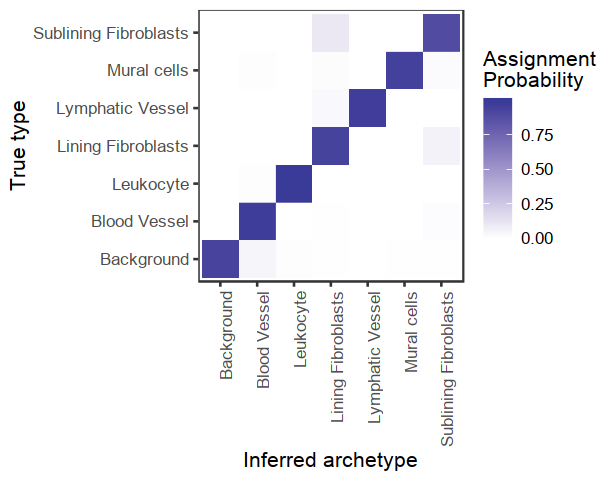

In [673]:
fig.size(4, 5)
library(pheatmap)
## Pr(archetype|celltype)
confusion_matrix <- plt_df %>% 
    with(table(cell_type, archetype)) %>% 
    prop.table(1) 
confusion_matrix[is.na(confusion_matrix)] <- 0

confusion_matrix %>% 
    data.table() %>% 
    ggplot(aes(archetype, cell_type, fill = N)) + 
        geom_tile_rast() + 
        scale_fill_gradient2(midpoint = 0) + 
        theme_test(base_size = 12) + 
        labs(fill = 'Assignment\nProbability', x = 'Inferred archetype', y = 'True type') + 
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
        NULL
  
ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/archetypes_confusion.pdf', device = "pdf", 
       dpi = 300, width = 5, height = 4, useDingbats = FALSE)

## 2b

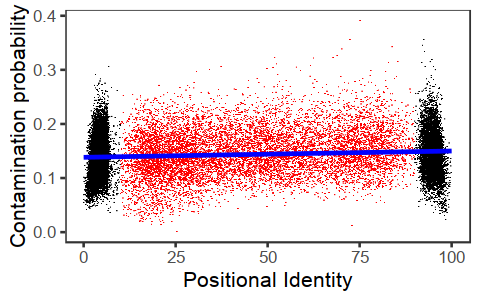

In [692]:
fig.size(2.5, 4)
tissue$meta_data %>% 
    cbind(soup = tissue$archetype_assignments$soup) %>% 
    subset(!is.na(time)) %>% 
    ggplot(aes(100 - time, soup, color = (time > 10 & time < 90))) + 
        geom_point_rast(shape = '.', dpi = 300, width = 4, height = 3) + 
        theme_test(base_size = 12) + 
        labs(x = 'Positional Identity', y = 'Contamination probability') + 
        guides(color = FALSE) + 
        geom_smooth(color = 'blue', method = 'lm') + 
        scale_color_manual(values = c(`TRUE` = 'red', `FALSE` = 'black')) + 
        NULL

ggsave(filename = '/data/srlab/ik936/NOTCH/paper/figures_supp/archetypes_pseudotime.pdf', device = "pdf", 
       dpi = 300, width = 4, height = 2.5, useDingbats = FALSE)

# Figure 3


## 3b

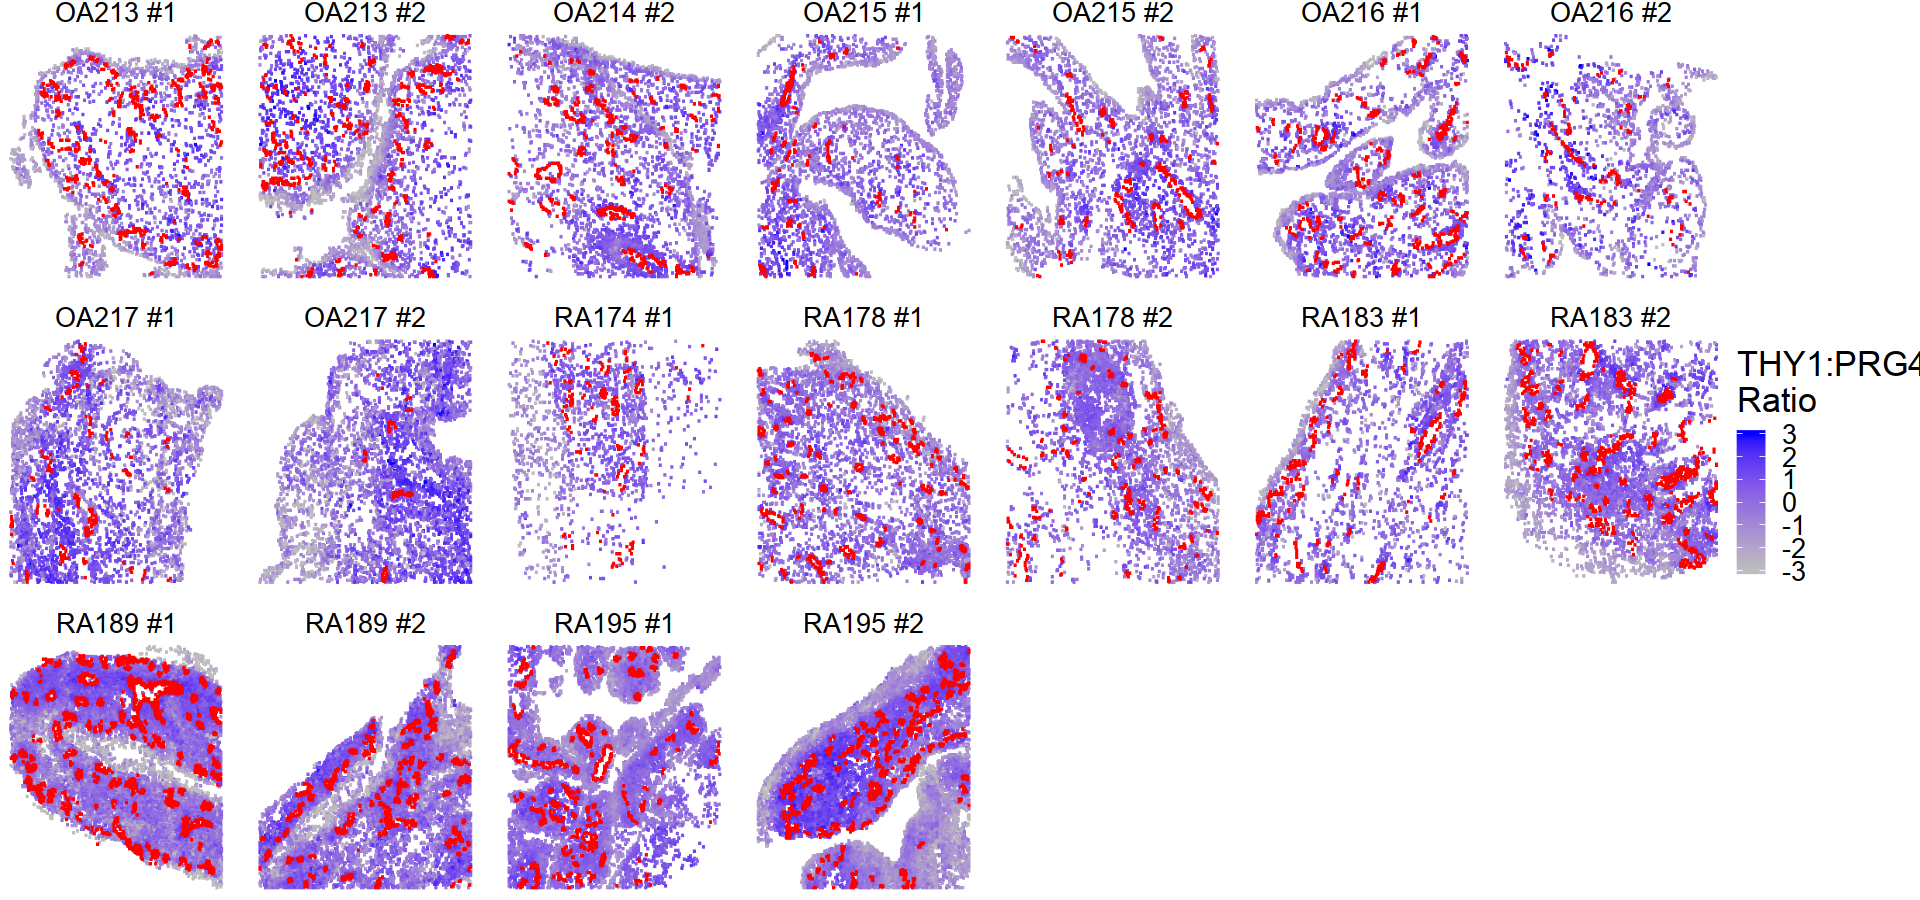

In [273]:
fig.size(7.5, 16)
data_if %>% 
    subset(ncells_image > 1000) %>% 
    dplyr::mutate(ID = sprintf("%s #%s", Sample, Image.number)) %>% 
    ggplot(aes(100 * center_x, 100 * center_y)) + 
        geom_point_rast(dpi = 300, height = 1, width = 1, data = . %>% subset(is_ec != 1), aes(color = ratio), shape = '.') + ## non-ECs
        geom_point_rast(dpi = 300, height = 1, width = 1, data = . %>% subset(cell_type == 'bldvessel' & is_ec == 1), color = 'red', shape = '.') + ## EC cells
        theme_void(base_size = 20, base_family = 'Helvetica') + 
        scale_color_gradient2(mid = "grey", high = "blue", midpoint = -3) + 
        guides(area = FALSE, size = FALSE) + 
        labs(color = 'THY1:PRG4\nRatio') + 
        labs(x = 'x position (um)', y = 'y position (um)') + 
        facet_wrap(~ID, scales = 'free', nrow = 3, ncol = 7) + 
        NULL

ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/if_scatter.pdf', device = "pdf", 
       dpi = 300, width = 16, height = 7.5, useDingbats = FALSE)  


## 3c: distances

In [5]:
data_if_binned <- split(1:nrow(data_if), paste0(data_if$Sample, data_if$Image.number)) %>% lapply(function(idx) {
    data_if[idx, ] %>% 
        subset(!is.na(dist_EC2)) %>% 
        bin_95("dist_EC2", c("CD146", "ratio"), 100, FALSE) %>% 
        cbind(data_if[idx, ] %>% dplyr::select(Sample, Image.number, ncells_image) %>% unique)
})
data_if_binned <- Reduce(rbind, data_if_binned)


Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”

In [6]:
cor_res <- data.table(data_if)[, broom::tidy(cor.test(~dist_EC2 + ratio, .SD, method = 'spearman')), by = .(Sample, Image.number)]

Warning message in cor.test.default(x = c(122.622471433761, 80.0577522866065, 68.6234782625106, :
“Cannot compute exact p-value with ties”Warning message in cor.test.default(x = c(46.8249455608214, 29.2553067600399, 18.7635225275879, :
“Cannot compute exact p-value with ties”Warning message in cor.test.default(x = c(68.7374421162962, 78.4270845696136, 87.4193054165173, :
“Cannot compute exact p-value with ties”Warning message in cor.test.default(x = c(66.297014823389, 104.593723036971, 93.3529290636842, :
“Cannot compute exact p-value with ties”Warning message in cor.test.default(x = c(4.36224156639054, 174.550321290607, 50.992732699156, :
“Cannot compute exact p-value with ties”Warning message in cor.test.default(x = c(124.91403983455, 55.1832054708147, 38.3585084011793, :
“Cannot compute exact p-value with ties”Warning message in cor.test.default(x = c(67.4040434169367, 57.2861963563371, 69.8838545877735, :
“Cannot compute exact p-value with ties”Warning message in cor.test.default(x

In [7]:
cor_res %>% with(max(p.value))

[1] 6.641515e-14

Joining, by = c("Sample", "Image.number")


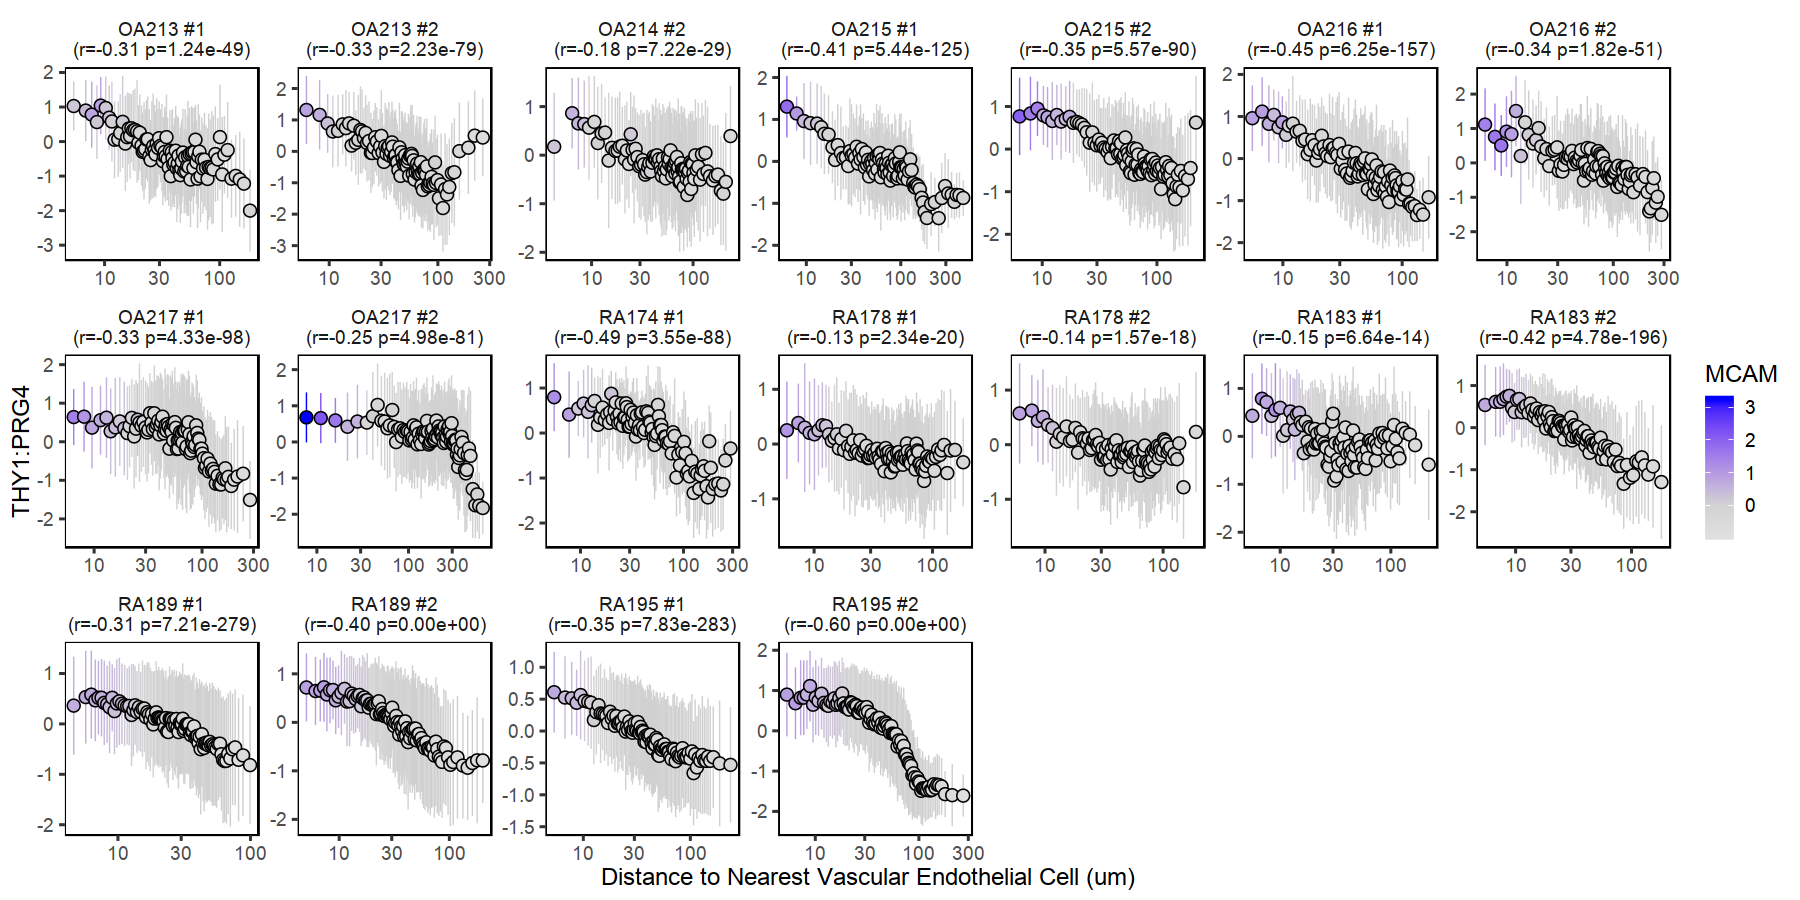

In [12]:
fig.size(7.5, 15)
data_if_binned %>% 
    subset(symbol == "ratio") %>% 
    subset(ncells_image > 1000) %>% 
    cbind(    
        MCAM = data_if_binned %>% subset(symbol == "CD146") %>% with(yval)    
    ) %>% 
    dplyr::inner_join(cor_res) %>% 
    dplyr::mutate(ID = sprintf("%s #%s\n(r=%.2f p=%.2e)", Sample, Image.number, estimate, p.value)) %>% 
    ggplot(aes(xval, yval)) + 
        geom_errorbar(width=0, aes(ymin=yval - ysd, ymax=yval + ysd, color = MCAM), size = .3) +
        geom_point(shape = 21, size = 3, aes(fill = MCAM)) + 
        scale_color_gradient2(low = "grey", high = "blue", mid = "lightgrey") + 
        scale_fill_gradient2(low = "white", high = "blue", mid = "lightgrey") + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + 
        theme(panel.background = element_rect()) + 
        labs(y = "THY1:PRG4", x = "Distance to Nearest Vascular Endothelial Cell (um)") + 
        guides(color = FALSE) + 
        scale_x_log10() + 
        facet_wrap(~ID, scales = "free", nrow = 3, ncol = 7) + 
        NULL


ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/if_corr.pdf', device = "pdf", 
       dpi = 300, width = 15, height = 7.5, useDingbats = FALSE)  


# Figure 5

In [505]:
data_if <- fread("/data/srlab/ik936/NOTCH/paper/figures_supp/tableS4_cd55.txt") %>% 
    data.frame()

## 5b

In [ ]:
fig.size(7.5, 16)
data_if %>% 
    dplyr::mutate(ID = sprintf("%s #%s", Sample, Image.number)) %>% 
    ggplot(aes(100 * center_x, 100 * center_y)) + 
        geom_point_rast(raster.dpi = 300, raster.height = 1, raster.width = 1, 
                        data = . %>% subset(is_ec != 1), aes(color = ratio), shape = '.') + ## non-ECs
        geom_point_rast(raster.dpi = 300, raster.height = 1, raster.width = 1, 
                        data = . %>% subset(cell_type == 'bldvessel' & is_ec == 1), color = 'red', shape = '.') + ## EC cells
#         geom_point(data = . %>% subset(is_ec != 1), aes(color = ratio), shape = '.') + ## non-ECs
#         geom_point(data = . %>% subset(cell_type == 'bldvessel' & is_ec == 1), color = 'red', shape = '.') + ## EC cells
        theme_void(base_size = 20, base_family = 'Helvetica') + 
        scale_color_gradient2(mid = "grey", high = "blue", midpoint = -3) + 
        guides(area = FALSE, size = FALSE) + 
        labs(color = 'CD90:CD55\nRatio') + 
        labs(x = 'x position (um)', y = 'y position (um)') + 
        facet_wrap(~ID, scales = 'free', nrow = 3) + 
        NULL

# ggsave('scatter_cd55.pdf',
#        device = "pdf", dpi = 300, width = 16, height = 7.5, useDingbats = FALSE)  


Warning message:
“Ignoring unknown parameters: raster.dpi, raster.height, raster.width”Warning message:
“Ignoring unknown parameters: raster.dpi, raster.height, raster.width”

## 5c

In [ ]:
data_if_binned <- split(1:nrow(data_if), paste0(data_if$Sample, data_if$Image.number)) %>% lapply(function(idx) {
    data_if[idx, ] %>% 
        subset(!is.na(dist_EC2)) %>% 
        bin_95("dist_EC2", c("CD146", "ratio"), 50, FALSE) %>% 
        cbind(data_if[idx, ] %>% dplyr::select(Sample, Image.number, ncells_image) %>% unique)
})
data_if_binned <- Reduce(rbind, data_if_binned)


In [ ]:
suppressWarnings({
    cor_res <- data.table(data_if)[, broom::tidy(cor.test(~dist_EC2 + ratio, .SD, method = 'spearman')), by = .(Sample, Image.number)]
})
    

In [ ]:
fig.size(7.5, 15)
data_if_binned %>% 
    subset(symbol == "ratio") %>% 
#     subset(ncells_image > 1000) %>% 
    cbind(    
        MCAM = data_if_binned %>% subset(symbol == "CD146") %>% with(yval)    
    ) %>% 
    dplyr::inner_join(cor_res) %>% 
    dplyr::mutate(ID = sprintf("%s #%s\n(r=%.2f p=%.2e)", Sample, Image.number, estimate, p.value)) %>% 
    ggplot(aes(xval, yval)) + 
        geom_errorbar(width=0, aes(ymin=yval - ysd, ymax=yval + ysd, color = MCAM), size = .3) +
        geom_point(shape = 21, size = 3, aes(fill = MCAM)) + 
        scale_color_gradient2(low = "grey", high = "blue", mid = "lightgrey") + 
        scale_fill_gradient2(low = "white", high = "blue", mid = "lightgrey") + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + 
        theme(panel.background = element_rect()) + 
        labs(y = "CD90:CD55", x = "Distance to Nearest Vascular Endothelial Cell (um)") + 
        guides(color = FALSE) + 
        scale_x_log10() + 
        facet_wrap(~ID, scales = "free", nrow=3) + 
        NULL


# ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/if_corr.pdf', device = "pdf", 
#        dpi = 300, width = 12, height = 8, useDingbats = FALSE)  

# ggsave('corr_cd55.pdf',
#        device = "pdf", dpi = 300, width = 15, height = 7.5, useDingbats = FALSE)  


# Figure 6

In [ ]:
data_if <- fread("/data/srlab/ik936/NOTCH/paper/figures_supp/tableS5_ggt5.txt") %>% 
    data.frame()

## 6b

In [ ]:
fig.size(7.5, 16)
data_if %>% 
    dplyr::mutate(ID = sprintf("%s #%s", Sample, Image.number)) %>% 
    ggplot(aes(100 * center_x, 100 * center_y)) + 
        geom_point_rast(raster.dpi = 300, raster.height = 1, raster.width = 1, data = . %>% subset(is_ec != 1), aes(color = ratio), shape = '.') + ## non-ECs
        geom_point_rast(raster.dpi = 300, raster.height = 1, raster.width = 1, data = . %>% subset(cell_type == 'bldvessel' & is_ec == 1), color = 'red', shape = '.') + ## EC cells
#         geom_point(data = . %>% subset(is_ec != 1), aes(color = ratio), shape = '.') + ## non-ECs
#         geom_point(data = . %>% subset(cell_type == 'bldvessel' & is_ec == 1), color = 'red', shape = '.') + ## EC cells
        theme_void(base_size = 20, base_family = 'Helvetica') + 
        scale_color_gradient2(mid = "grey", high = "blue", midpoint = -3) + 
        guides(area = FALSE, size = FALSE) + 
        labs(color = 'CD90:CD55\nRatio') + 
        labs(x = 'x position (um)', y = 'y position (um)') + 
        facet_wrap(~ID, scales = 'free', nrow = 3) + 
        NULL

# ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/if_scatter.pdf', device = "pdf", 
#        dpi = 300, width = 16, height = 7.5, useDingbats = FALSE)  
ggsave('scatter_ggt5.pdf',
       device = "pdf", dpi = 300, width = 16, height = 7.5, useDingbats = FALSE)  


## 6c

In [ ]:
data_if_binned <- split(1:nrow(data_if), paste0(data_if$Sample, data_if$Image.number)) %>% lapply(function(idx) {
    data_if[idx, ] %>% 
        subset(!is.na(dist_EC2)) %>% 
        bin_95("dist_EC2", c("ratio"), 50, FALSE) %>% 
        cbind(data_if[idx, ] %>% dplyr::select(Sample, Image.number, ncells_image) %>% unique)
})
data_if_binned <- Reduce(rbind, data_if_binned)


suppressWarnings({
    cor_res <- data.table(data_if)[, broom::tidy(cor.test(~dist_EC2 + ratio, .SD, method = 'spearman')), by = .(Sample, Image.number)]
})
    

In [ ]:
fig.size(8, 12)
data_if_binned %>% 
    subset(symbol == "ratio") %>% 
    subset(ncells_image > 1000) %>% 
    dplyr::inner_join(cor_res) %>% 
    dplyr::mutate(ID = sprintf("%s #%s\n(r=%.2f p=%.2e)", Sample, Image.number, estimate, p.value)) %>% 
    ggplot(aes(xval, yval)) + 
        geom_errorbar(width=0, aes(ymin=yval - ysd, ymax=yval + ysd), size = .3) +
        geom_point(shape = 21, size = 3) + 
#         scale_color_gradient2(low = "grey", high = "blue", mid = "lightgrey") + 
        scale_fill_gradient2(low = "white", high = "blue", mid = "lightgrey") + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + 
        theme(panel.background = element_rect()) + 
        labs(y = "PDPN:GGT5", x = "Distance to Nearest Vascular Endothelial Cell (um)") + 
#         guides(color = FALSE) + 
        scale_x_log10() + 
        facet_wrap(~ID, scales = "free", nrow=3) + 
        NULL


# ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/if_corr.pdf', device = "pdf", 
#        dpi = 300, width = 12, height = 8, useDingbats = FALSE)  
ggsave('corr_ggt5.pdf',
       device = "pdf", dpi = 300, width = 15, height = 7.5, useDingbats = FALSE)  


# Figure 7: organoids

## 7ab

In [477]:
fig.size(2.5, 10)
with(joint, {
    idx_mm <- which(meta_data$source == "culture")
    idx_pr <- which(meta_data$source == "primary" & meta_data$cell_type %in% c("lining", "sublining"))
    
    plt_df <- ddr_Z %>% data.frame() %>% 
        cbind(meta_data[c(idx_pr, idx_mm), ]) %>% 
        dplyr::mutate(label = ifelse(source == 'culture', donor, disease)) %>% 
        subset(!cell_type %in% c("blood")) %>%     
        dplyr::mutate(label = ifelse(grepl("^MM", donor), donor, "synovial tissue")) %>% 
        dplyr::arrange(source == "culture") %>% ## put MM cells on top
        dplyr::mutate(label = ifelse(label == "MM1", "fibroblast", label)) %>% 
        dplyr::mutate(label = ifelse(label == "MM2", "fibroblast + blood vessel", label)) 
    
    plt_df %>% 
        subset(source == "culture") %>% 
        ggplot(aes(-X2, X1)) +
            guides(color = FALSE) + 
            geom_point_rast(dpi = 300, width = 2, height = 2,
                color = "lightgrey", 
                data = plt_df %>% subset(source == 'primary') %>% dplyr::select(-label), 
                shape = '.', alpha = .5
            ) + 
            geom_point(data = data.frame(t(tissue$ddrtree_res$Y)), color = 'black') + 
            geom_point_rast(
                data = . %>% subset(source == "culture" & time < 80), color = '#F28E2B',
                dpi = 300, width = 2, height = 2, shape = '.'
            ) + 
            geom_point_rast(
                data = . %>% subset(source == "culture" & time > 80), color = 'red',
                dpi = 300, width = 2, height = 2, shape = '.'
            ) + 
            labs(x = "DDRTree 2", y = "DDRTree 1") + 
            theme_tufte(base_size = 14, base_family = "Helvetica") + #geom_rangeframe(color = "black") + 
            theme(panel.background = element_rect(), strip.text = element_blank()) + 
            facet_wrap(~label, ncol = 2) + 
            NULL

    ggsave('/data/srlab/ik936/NOTCH/paper/figure2/ddrtree_mm.pdf', device = "pdf", 
           dpi = 300, width = 10, height = 2.5, useDingbats = FALSE)    

})



# 7c: Correlation of %CD90+ with %ECs


In [291]:
str <- "	endothelial cells	CD90+ fibroblasts
RA160525A	22.7	92.5
RA160902	18.6	63.7
RA160715	17.3	91.9
CL160526	15.7	70.7
RA160908	15.2	68.1
RA160425	13.8	88.5
OA160822B	9	81.7
RA160513	6.99	91.1
OA160822A	6.02	51.9
OA160609(1)	5.38	55.4
RA160531	5.32	74.4
Bx16006	3.67	87.2
OA160512	3.61	38.85
OA160617	3.4	62.6
OA160908	2.76	17.41
RA160606	2.74	5.59
OA160609(2)	1.69	47.4
RA160929	1.67	40.4
OA160512A	1.434	18.6
OA160819	0.88	36.1
OA160512	0.71	30.9
OA032816	0.62	29.5
OA160909		"

fig.size(3, 5)
data_df <- fread(text = str) %>% 
    subset(!is.na(`endothelial cells`) & !is.na(`CD90+ fibroblasts`)) 

cor_res <- cor.test(~ `endothelial cells` + `CD90+ fibroblasts` , data_df, method = 'spearman') %>% broom::tidy()

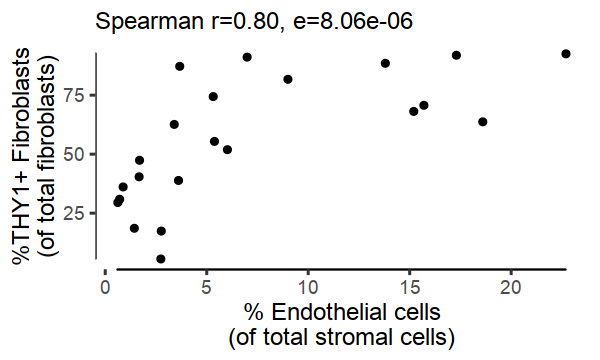

In [297]:
data_df %>% 
    ggplot(aes(`endothelial cells`, `CD90+ fibroblasts`)) + 
        geom_point() + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + 
        geom_rangeframe() + 
        labs(y = '%THY1+ Fibroblasts\n(of total fibroblasts)', 
             x = '% Endothelial cells\n(of total stromal cells)', 
             subtitle = sprintf('Spearman r=%.2f, e=%.2e', cor_res$estimate, cor_res$p.value)) + 
#         scale_y_log10() + 
        NULL

ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/endo_proportion.pdf', device = "pdf", 
       dpi = 300, width = 5, height = 3, useDingbats = FALSE)  


## 7d: Doppler


In [337]:
str <- "0	1	2
61.22	70.84	92.64
48.37	75	98.43
61.17	96.29	97.65
83.32	91.09	90.1
	93.85	89.02
66.38		80.6
53.06		95.95
		99.86
		78.57"

# fig.size(3, 5)
data_df <- fread(text = str, skip = 1) %>% 
    tidyr::gather(dop, val) %>% 
    dplyr::mutate(dop = as.numeric(gsub('V', '', dop))) %>% 
    subset(!is.na(val)) 

cor_res <- cor.test(~ `dop` + `val` , data_df, method = 'spearman') %>% broom::tidy()

Warning message in cor.test.default(x = c(1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, :
“Cannot compute exact p-value with ties”

In [339]:
table(data_df$dop)


1 2 3 
6 5 9 

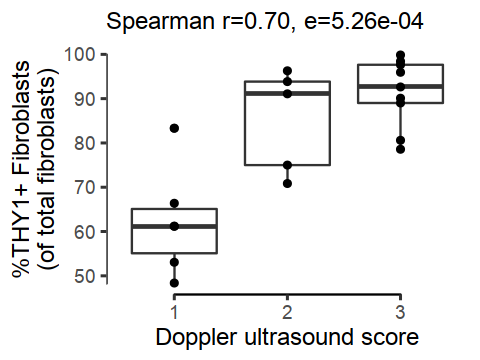

In [321]:
fig.size(3, 4)
data_df %>% 
    ggplot(aes(dop, val)) + 
        geom_boxplot(data = . %>% dplyr::mutate(dop = factor(dop))) + 
        geom_point() + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + 
        geom_rangeframe() + 
        labs(y = '%THY1+ Fibroblasts\n(of total fibroblasts)', 
             x = 'Doppler ultrasound score', 
             subtitle = sprintf('Spearman r=%.2f, e=%.2e', cor_res$estimate, cor_res$p.value)) + 
#         scale_x_continuous(breaks = 1:3) +
        NULL

ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/doppler.pdf', device = "pdf", 
       dpi = 300, width = 4, height = 3, useDingbats = FALSE)  


# Figure 10

## 10a

In [477]:
fig.size(2.5, 5)
with(tissue, {
    idx <- which(meta_data$cell_type == 'pericytes')
    do_scatter(umap_harmony[idx, ], meta_data[idx, ], 'cell_subtype', pt_size = 12, no_guides = FALSE, w = 4, h = 3,
                              palette_use = tableau_color_pal('Tableau 10')(2), do_labels = FALSE) + 
    NULL    
    ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/umap_mural.pdf', device = "pdf", 
           dpi = 300, width = 5, height = 2.5, useDingbats = FALSE)    
})



## 10b

In [479]:
# features <- paste0('Notch', 1:4)
features <- c('PDGFRB', 'SPARC', 'THY1', 'GGT5', 'MYH11', 'DES', 'ACTA2', 'MYL9')

fig.size(5, 12)
with(tissue, {
#     idx <- umap_harmony[, 2] > 7 & umap_harmony[, 2] < 12
    idx <- which(meta_data$cell_type == 'pericytes')
    (plt <- plotFeatures(exprs_norm[, idx], umap_harmony[idx, ], order_by_expression = FALSE, no_guide = TRUE, w = 4 * 1, h = 3 * 1,
                 features, nrow = 2, qlo = 0.1, qhi = .9, pt_shape = 16, color_high = 'red'))
    ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/human_mural_cell_markers.pdf', plot = plt, device = "pdf", 
           dpi = 300, width = 12, height = 5, useDingbats = FALSE)  
})




## 10c

In [483]:
plt_df <- tissue$meta_data[idx_mural, ] %>% 
    cbind(t(as.matrix(tissue$exprs_norm[c('NOTCH1', 'NOTCH3'), idx_mural]))) %>% 
    tidyr::gather(feature, val, NOTCH1, NOTCH3)

fig.size(2, 4)
library(ggridges)
(plt <- plt_df %>% 
     subset(feature == 'NOTCH3') %>% 
#     ggplot(aes(val, label_nice)) + 
#     ggplot(aes(val, cell_subtype)) + 
#     subset(cell_subtype %in% c('lining', 'pericytes', 'Venous', 'Arterial', 'sublining')) %>% 
#     subset(!cell_type %in% c('leukocytes', '', 'lymph')) %>% 
#     subset(!is.na(cell_type)) %>% 
    ggplot(aes(val, color = cell_subtype)) + 
#     ggplot(aes(val, color = cell_subtype)) + 
        geom_density(aes(y = ..scaled..)) + 
#         geom_density_ridges(aes(height =..ndensity..), scale = 1.2) + 
#         geom_density_ridges(scale = 1.2) + 
        theme_tufte(base_size = 12) + geom_rangeframe(color = 'black') + 
        scale_color_tableau() + 
#         geom_vline(xintercept = 0, linetype = 2) + 
#         labs(x = 'Notch activation score', y = '', title = 'Notch activation score') + 
#         facet_wrap(~feature, scales = 'free_x') + 
        guides(color = FALSE) + 
        labs(y = 'Scaled Density', x = '') + 
        NULL)

ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/human_notch_ridges_mural.pdf', device = "pdf", plot = plt,
       dpi = 300, width = 4, height = 2, useDingbats = FALSE)  

## 10f

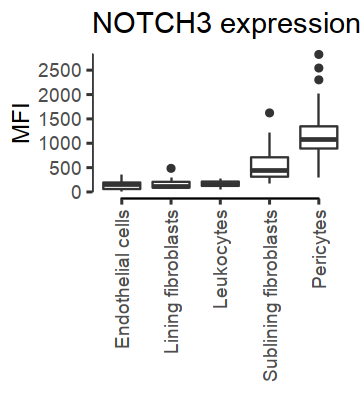

In [385]:
data_df <- fread("/data/srlab/ik936/NOTCH/data/Manuscript_data/Figure 3/Notch3 expression by flow in fibroblasts subsets.txt")

fig.size(3.5, 3)
data_df %<>% 
    tidyr::gather(type, value) %>% 
    subset(!is.na(value)) %>% 
    subset(value > 0) 

data_df %>% 
    ggplot(aes(reorder(type, value), value + 1)) + 
        geom_boxplot() + 
#         geom_point(shape = 21, position = position_jitter(width = .1, height = 0), size = 1) + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + 
        geom_rangeframe() + 
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) + 
        labs(y = 'MFI', x = '', fill = '', color = '', title = 'NOTCH3 expression') + 
        scale_y_continuous(breaks = seq(0, 3000, 500)) + 
#         scale_y_log10() + 
        NULL

ggsave('/data/srlab/ik936/NOTCH/paper/figure3/notch3_mfi.pdf', device = "pdf", 
       dpi = 300, width = 3, height = 3.5, useDingbats = FALSE)

In [354]:
type_levels <- data.table(data_df)[, (median(value)), by = type][order(V1), type]

data_df %>% 
    dplyr::mutate(type = factor(type, type_levels)) %>% 
    with(cor.test(~ value + as.integer(type), method = 'spearman') %>% broom::tidy())
#     with(t.test(value ~ type))

Warning message in cor.test.default(x = c(267, 155, 255, 221, 175, 233, 51.6, 92.4, :
“Cannot compute exact p-value with ties”

estimate,statistic,p.value,method,alternative
0.8098348,44524.53,3.106005e-27,Spearman's rank correlation rho,two.sided


# Figure 11

## 11a

In [293]:
fig.size(2.5, 5)
with(tissue, {
    meta_tmp <- meta_data %>% 
        dplyr::mutate(temp = case_when(
            cell_subtype %in% c('Arterial', 'Venous') ~ cell_subtype,
            TRUE ~ 'other'
        ))
    do_scatter(umap_harmony, meta_tmp, 'temp', palette_use = c(Venous = tableau_color_pal()(2)[1], Arterial = tableau_color_pal()(2)[2], other = 'grey'))
    
    ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/mouse_umap_endo_subtypes.pdf', device = "pdf", 
           dpi = 300, width = 5, height = 2.5, useDingbats = FALSE)  
    
})

Warning message:
“Ignoring unknown parameters: label.size”

## 11b

In [395]:
markers_endo <- wilcoxauc(tissue$exprs_norm, tissue$meta_data$cell_subtype, groups_use = c('Arterial', 'Venous'))

In [428]:
markers_endo %>% 
    subset(feature %in% c('DLL4', 'JAG1'))

,feature,group,avgExpr,logFC,statistic,auc,pval,padj,pct_in,pct_out
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9843,DLL4,Arterial,0.36477724,0.2748850,4135451,0.5891401,1.338237e-75,1.699143e-73,24.655312,7.553135
9844,DLL4,Venous,0.08989221,-0.2748850,2884018,0.4108599,1.338237e-75,1.699143e-73,7.553135,24.655312
16033,JAG1,Arterial,0.42923189,0.3013715,4119558,0.5868761,3.691014e-57,3.408315e-55,27.088402,11.031091
16034,JAG1,Venous,0.12786038,-0.3013715,2899910,0.4131239,3.691014e-57,3.408315e-55,11.031091,27.088402


In [423]:
genes_df <- markers_endo %>% 
    subset(!grepl('^RPS|^RPL|^MT', feature, ignore.case = TRUE)) %>% 
    top_markers(5) %>%
    tidyr::gather(group, feature, -rank) %>% 
    subset(group != 'Other')

genes_df <- rbind(data.table(rank = 1:2, group = 'Arterial', feature = c('JAG1', 'DLL4')), genes_df)


rank,group,feature
<int>,<chr>,<chr>
1,Arterial,JAG1
2,Arterial,DLL4
1,Arterial,SLC9A3R2
2,Arterial,A2M
3,Arterial,PODXL
4,Arterial,CXCL12
5,Arterial,NOTCH4
1,Venous,DARC
2,Venous,ADIRF


In [425]:
with(tissue, {
    cell_levels <- c('Arterial', 'Venous')
    gene_levels <- rev(genes_df$feature)
    
    X <- markers_endo %>% 
        subset(feature %in% gene_levels)

    X$cell_subtype <- X$group
    data_plot <- X %>%
#         dplyr::left_join(genes_df) %>% 
        dplyr::mutate(feature = factor(feature, gene_levels)) %>%
        dplyr::mutate(pct_in = ifelse(is.na(pct_in), 0, pct_in)) %>% 
        dplyr::mutate(avgExpr = ifelse(is.na(avgExpr), 0, avgExpr)) %>% 
        dplyr::group_by(feature) %>% 
#         mutate(avgExpr = scale(avgExpr)) %>% 
#         mutate(avg_exp_scale = MinMax(avgExpr, max = 2.5, min = -2.5)) %>%
#         mutate(avg_exp_scale = MinMax(avgExpr, max = 5, min = 0)) %>%
        dplyr::mutate(avg_exp_scale = avgExpr) %>% 
        ungroup() %>%
        identity()
    
    fig.size(3.9, 2.5)
    data_plot %>% 
        dplyr::mutate(cell_subtype = factor(cell_subtype, cell_levels)) %>% 
        subset(!is.na(cell_subtype)) %>% 
        ggplot(aes(cell_subtype, feature)) + 
            geom_point(aes(size = pct_in, color = avg_exp_scale)) + 
            scale_color_gradient2(mid = 'lightgrey', high = muted('blue'), midpoint = min(data_plot$avg_exp_scale)) + 
            scale_size_area(max_size = 4) + 
            theme(axis.title.x = element_blank(), axis.title.y = element_blank()) + 
            scale_x_discrete(labels = nice_names_list) + 
            theme_tufte() + theme(panel.background = element_rect()) + 
            theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
            labs(x = "", y = "", size = '%Cells\nExpressing', color = 'Mean\nExpression\n(scaled)') + 
            NULL    
    
    ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/dotplot_endo_subtypes.pdf', device = "pdf", 
           dpi = 300, width = 2.5, height = 4, useDingbats = FALSE)  
    
})

 

# Figure 12

In [ ]:
data_if <- fread("CD55 data/tableS7_podxl.txt")


## 12b

In [ ]:
fig.size(2, 10)
data_if %>% 
    dplyr::mutate(ID = sprintf("%s #%s", Sample, Image.number)) %>% 
    ggplot(aes(100 * center_x, 100 * center_y)) + 
        geom_point_rast(raster.dpi = 300, raster.height = 1.5, raster.width = 1.5, 
                        data = . %>% subset(is_ec != 1), aes(color = ratio), shape = '.') + ## non-ECs
        geom_point_rast(raster.dpi = 300, raster.height = 1.5, raster.width = 1.5, 
                        data = . %>% subset(cell_type == 'bldvessel' & is_ec == 1), color = 'red', shape = '.') + ## EC cells
#         geom_point(data = . %>% subset(is_ec != 1), aes(color = ratio), shape = '.') + ## non-ECs
#         geom_point(data = . %>% subset(cell_type == 'bldvessel' & is_ec == 1), color = 'red', shape = '.') + ## EC cells
        theme_void(base_size = 12, base_family = 'Helvetica') + 
        scale_color_gradient2(mid = "grey", high = "blue", midpoint = -3) + 
        guides(area = FALSE, size = FALSE) + 
        labs(color = 'Notch3') + 
        labs(x = 'x position (um)', y = 'y position (um)') + 
        facet_wrap(~ID, scales = 'free', nrow = 1) + 
        NULL

# ggsave('IF_analysis_images/scatter_podxl.pdf',
#        device = "pdf", dpi = 300, width = 10, height = 2, useDingbats = FALSE)  


## 12c

In [ ]:
data_if_binned <- split(1:nrow(data_if), paste0(data_if$Sample, data_if$Image.number)) %>% lapply(function(idx) {
    data_if[idx, ] %>% 
        subset(!is.na(dist_EC2)) %>% 
        bin_95("dist_EC2", c("ratio", 'CD90'), 50, FALSE) %>% 
        cbind(data_if[idx, ] %>% dplyr::select(Sample, Image.number, ncells_image) %>% unique)
})
data_if_binned <- Reduce(rbind, data_if_binned)


In [ ]:
suppressWarnings({
    cor_res <- data.table(data_if)[, broom::tidy(cor.test(~dist_EC2 + ratio, .SD, method = 'spearman')), by = .(Sample, Image.number)]
})
    

In [ ]:
fig.size(2, 10)
data_if_binned %>% 
    subset(symbol == "ratio") %>% 
#     subset(ncells_image > 1000) %>% 
    dplyr::inner_join(cor_res) %>% 
    dplyr::mutate(ID = sprintf("%s #%s\n(r=%.2f p=%.2e)", Sample, Image.number, estimate, p.value)) %>% 
    ggplot(aes(xval, yval)) + 
        geom_errorbar(width=0, aes(ymin=yval - ysd, ymax=yval + ysd), size = .3) +
        geom_point(shape = 21, size = 3) + 
        scale_color_gradient2(low = "grey", high = "blue", mid = "lightgrey") + 
        scale_fill_gradient2(low = "white", high = "blue", mid = "lightgrey") + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + 
        theme(panel.background = element_rect()) + 
        labs(y = "Notch3", x = "Distance to Nearest Arterial Cell (um)") + 
        guides(color = FALSE) + 
        scale_x_log10() + 
        facet_wrap(~ID, scales = "free", nrow=1) + 
        NULL



# ggsave('corr_podxl.pdf',
#        device = "pdf", dpi = 300, width = 10, height = 2, useDingbats = FALSE)  


# Figure 13

## 13b

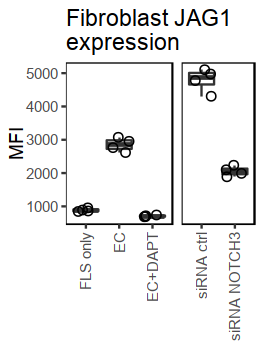

In [327]:
# data_df <- '/data/srlab/ik936/NOTCH/data/'
str <- '170908 coculture_DAPT_001_010.fcs   742
170908 coculture_DAPT_002_011.fcs   718
170908 coculture_DAPT_003_012.fcs   689
170908 coculture_DAPT_009.fcs   692
170908 coculture_coculture_001_006.fcs  2954
170908 coculture_coculture_002_007.fcs  3075
170908 coculture_coculture_003_008.fcs  2617
170908 coculture_coculture_005.fcs  2764
170908 coculture_fls_001_002.fcs    847
170908 coculture_fls_001.fcs    955
170908 coculture_fls_002_003.fcs    862
170908 coculture_fls_003_004.fcs    891
170908 coculture_siCTRL_001_022.fcs 4975
170908 coculture_siCTRL_002_023.fcs 4779
170908 coculture_siCTRL_003_024.fcs 5104
170908 coculture_siCTRL_021.fcs 4307
170908 coculture_siNOTCH3_2_001_018.fcs 1991
170908 coculture_siNOTCH3_2_002_019.fcs 2235
170908 coculture_siNOTCH3_2_003_020.fcs 2100
170908 coculture_siNOTCH3_2_017.fcs 1889'

fig.size(3, 2.2)

plt_df <- fread(text = str) %>% 
    dplyr::select(-V1) %>% 
    dplyr::mutate(V2 = gsub('(_\\d+)+.fcs', '', V2)) %>%
    dplyr::mutate(
        type = dplyr::case_when(
            V2 == 'coculture_DAPT' ~ 'EC+DAPT', 
            V2 == 'coculture_coculture' ~ 'EC', 
            V2 == 'coculture_fls' ~ 'FLS only', 
            V2 == 'coculture_siCTRL' ~ 'siRNA ctrl', 
            V2 == 'coculture_siNOTCH3' ~ 'siRNA NOTCH3')
    ) %>% 
    dplyr::mutate(
        type2 = dplyr::case_when(
            type %in% c('siRNA ctrl', 'siRNA NOTCH3') ~ 2,
            TRUE ~ 1    
        )
    ) %>% 
    dplyr::mutate(type = factor(type, c('FLS only', 'EC', 'EC+DAPT','siRNA ctrl', 'siRNA NOTCH3'))) 

plt_df %>% 
    ggplot(aes(type, V3)) + 
        geom_boxplot() + 
        geom_point(shape = 21, position = position_jitter(width = .3, height = 0), size = 2) + 

        theme_tufte() + 
        labs(x = '', y = 'MFI', title = 'Fibroblast JAG1\nexpression') + 
#         theme(plot.title = element_text(hjust = .5, size = 16)) + 
        theme(
            panel.background = element_rect(),
            axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5),
            strip.text = element_blank()        
        ) + 
        facet_grid(.~type2, scales = "free_x", space = "free_x") 

ggsave('/data/srlab/ik936/NOTCH/paper/figure3/jag1_mfi.pdf', device = "pdf", 
       dpi = 300, width = 2.2, height = 3, useDingbats = FALSE)

In [336]:
t.test(V3 ~ type, subset(plt_df, type %in% c('siRNA ctrl', 'siRNA NOTCH3')))



	Welch Two Sample t-test

data:  V3 by type
t = 14.423, df = 4.0483, p-value = 0.0001243
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 2212.999 3262.001
sample estimates:
  mean in group siRNA ctrl mean in group siRNA NOTCH3 
                   4791.25                    2053.75 


## 13c


## NOTCH3 vs JAG1

In [320]:
## First, in MM data
with(joint, {
    plt_df <<- exprs_norm[c("JAG1", "NOTCH3"), ] %>% 
        as.matrix() %>% t() %>% 
        data.frame() %>%
        cbind(meta_data) %>% 
        subset(!cell_type %in% c("endothelial", "leukocytes")) %>% ## keeps fibroblasts and pericytes
        identity()
})


cor_res <- data.table(plt_df)[, broom::tidy(cor.test(~NOTCH3 + JAG1, method = "pearson")), by = .(source)] %>% 
    identity()    


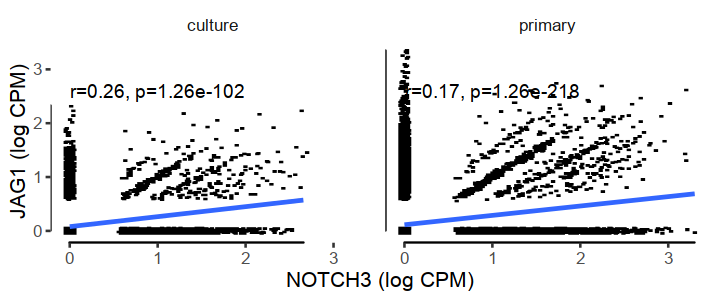

In [321]:
fig.size(2.5, 6)

plt_df %>% 
    ggplot(aes(NOTCH3, JAG1)) + 
        geom_point_rast(width = 1, height = 1, dpi = 300,
            shape = ".", position = position_jitter(width = .05, height = .05)
        ) + 
        theme_tufte(base_size = 12) + 
        geom_rangeframe() + 
        geom_text(
            data = cor_res, size = 4, 
            aes(x = 1, y = 2.6, label = sprintf("r=%.2f, p=%.2e", estimate, p.value))
        ) + 
        facet_wrap(~source) + 
        geom_smooth(method = "lm") + 
        labs(y = "JAG1 (log CPM)", x = "NOTCH3 (log CPM)") + 
        NULL

ggsave('/data/srlab/ik936/NOTCH/paper/figure3/jag_notch_corr.pdf', device = "pdf", 
       dpi = 300, width = 6, height = 2.5, useDingbats = FALSE)

## 13d

In [91]:
cutoff <- tissue$meta_data %>% 
    subset(cell_type %in% c('lining')) %>% 
    with(quantile(score_notch, c(.95))) %>% 
    unlist %>% 
    as.numeric %>% 
    round(1)

plt_df <- data.table(tissue$meta_data)[, sum(score_notch > cutoff) / .N, by = .(disease, donor)] 

wilcox.test(V1 ~ disease, plt_df)
t.test(V1 ~ disease, plt_df)


	Wilcoxon rank sum test

data:  V1 by disease
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Welch Two Sample t-test

data:  V1 by disease
t = -2.8203, df = 8.2643, p-value = 0.02177
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.36991464 -0.03813038
sample estimates:
mean in group oa mean in group ra 
      0.08081339       0.28483590 


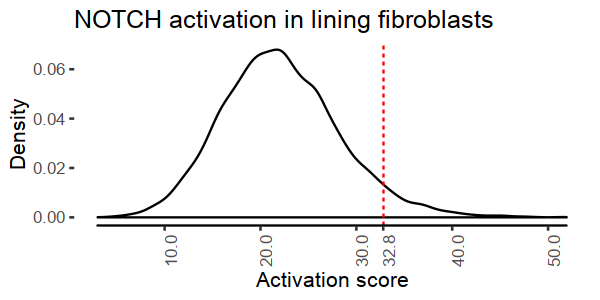

In [109]:
fig.size(2.5, 5)
tissue$meta_data %>% 
    subset(cell_type %in% c('lining')) %>% 
#     subset(cell_type %in% c('lining', 'sublining')) %>% 
    ggplot(aes(score_notch)) + 
#         geom_density(aes(y = ..scaled..)) + 
        geom_density() + 
        geom_vline(xintercept = cutoff, linetype = 2, color = 'red') + 
        scale_x_continuous(breaks = c(cutoff, seq(0, 100, 10))) + 
        labs(x = 'Activation score', title = 'NOTCH activation in lining fibroblasts',  y = 'Density') +
        theme_tufte(base_size = 12) + geom_rangeframe() + 
        theme(axis.text.x = element_text(angle = 90, hjust = 1))

ggsave('/data/srlab/ik936/NOTCH/paper/figure3/notch_activation_cutoff.pdf', device = "pdf", 
       dpi = 300, width = 5, height = 2.5, useDingbats = FALSE)

# Figure 16

In [170]:
# types_use <- c('lining', 'myeloid', '' 'intermediate', 'sublining', 'pericyte_VSMC')
types_use <- unique(mouse$meta_data$cell_type) %>% setdiff(c(NA, '', 'NA'))
dge <- Reduce(rbind, lapply(types_use, function(type_use) {
    message(type_use)
    idx <- which(!grepl('BRI280', mouse$meta_data$donor) & 
                 mouse$meta_data$status == 'case' & 
                 mouse$meta_data$cell_type == type_use &  
                 mouse$meta_data$label %in% c('WT', 'KO'))
    dge_ko <- wilcoxauc(mouse$exprs_norm[, idx], mouse$meta_data$label[idx]) %>% 
        subset(group == 'KO') %>% 
        dplyr::select(-group)    

    idx <- which(!grepl('BRI280', mouse$meta_data$donor) & 
                 mouse$meta_data$status == 'case' & 
                 mouse$meta_data$cell_type == type_use &  
                 mouse$meta_data$label %in% c('ISO', 'N3'))

    dge_mab <- wilcoxauc(mouse$exprs_norm[, idx], mouse$meta_data$label[idx]) %>% 
        subset(group == 'N3') %>% 
        dplyr::select(-group)

    dplyr::inner_join(dge_ko, dge_mab, by = c('feature'), suffix = c('_ko', '_mab')) %>% 
        dplyr::mutate(cell_type = type_use)
    
}))



sublining
lining
tcell
myeloid
intermediate
venous
neutrophil
bcell
chondrocytes
pericyte_VSMC
arterial


In [171]:
suppressWarnings({
    cor_res <- data.table(dge)[
#         padj_ko < .05 | padj_mab < .05, 
        ,
        broom::tidy(cor.test(~ logFC_ko + logFC_mab, method = 'spearman')), 
        by = cell_type
    ][
        order(-estimate)
    ]
})
    

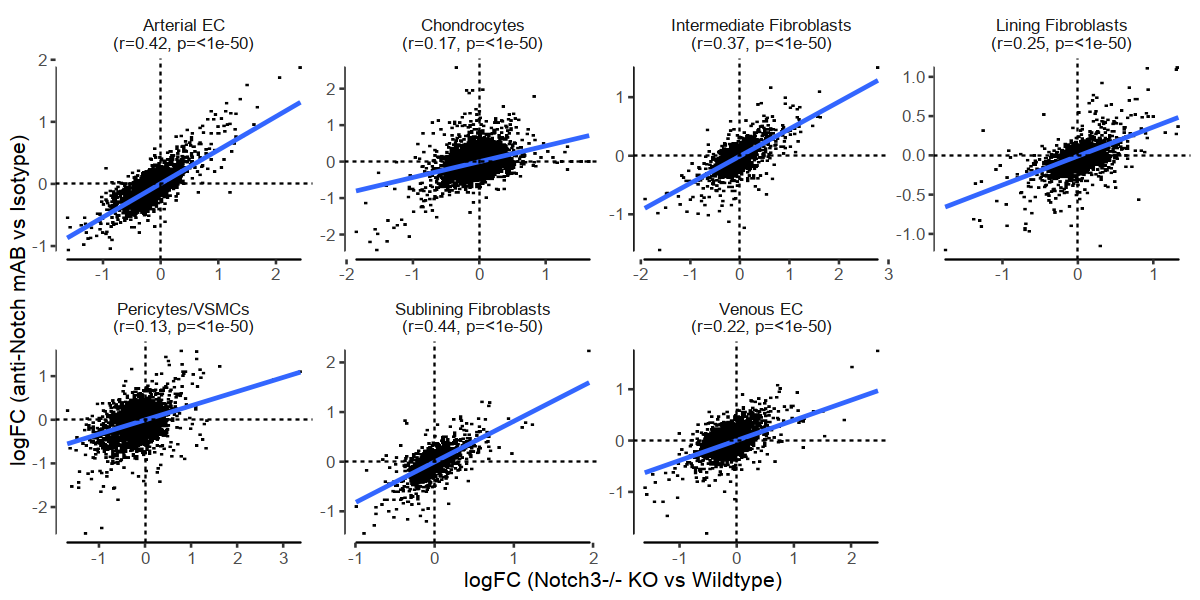

In [275]:
fig.size(5, 10)
dge %>% 
    dplyr::inner_join(cor_res, by = 'cell_type') %>% 
    dplyr::inner_join(nice_names, by = c('cell_type' = 'given_name')) %>%
    dplyr::mutate(cell_type = nice_name) %>% 
    subset(!cell_type %in% c('B cells', 'T cells', 'Neutrophils', 'Myeloid')) %>% 
    dplyr::mutate(p.value = ifelse(p.value < 1e-50, '<1e-50', sprintf('%.2e', p.value))) %>% 
    dplyr::mutate(cell_type = sprintf('%s\n(r=%.2f, p=%s)', cell_type, estimate, p.value)) %>% 
    ggplot(aes(logFC_ko, logFC_mab)) + 
        geom_point_rast(dpi = 300, width = 1, height = 1, shape = '.') + 
#         geom_point(shape = '.') + 
        geom_smooth(method = 'lm') + 
        theme_tufte(base_size = 12) + geom_rangeframe(color = 'black') + 
        geom_hline(yintercept = 0, linetype = 2) + 
        geom_vline(xintercept = 0, linetype = 2) + 
        facet_wrap(~cell_type, scales = 'free', nrow = 2) + 
        labs(
            y = 'logFC (anti-Notch mAB vs Isotype)',
            x = 'logFC (Notch3-/- KO vs Wildtype)'
        ) + 
        guides(color = FALSE) + 
        NULL

ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/mouse_logFC_logFC_scatter.pdf', device = "pdf", 
       dpi = 300, width = 10, height = 5, useDingbats = FALSE)  

# Figure 17

## 17ab


In [216]:
library(lme4)

In [217]:
datadir <- "/data/srlab/ik936/NOTCH/data/Manuscript_data/Supplemental figures/"

In [256]:
get_data <- function(fname) {
    plt_df <- fread(file.path(datadir, fname)) 
    colnames(plt_df) <- c('V1', tail(colnames(plt_df), -1))
    plt_df <- plt_df %>% 
        data.frame() %>% 
        tidyr::gather(sample, value, -V1) %>% 
        dplyr::mutate(value = gsub("\\*", "", value), 
                      value = as.numeric(value)) %>% 
        subset(!is.na(value)) %>% 
        dplyr::rename(timepoint = V1) %>% 
        dplyr::mutate(phenotype = ifelse(grepl("control|igg", sample, ignore.case = TRUE), "ctrl", "n1ko|N1KO")) 
    return(plt_df)
}


In [261]:
do_lineplot <- function(plt_df, xlab, ylab, pal, type, pval_pos, no_bottom = FALSE) {    
    suppressWarnings({
        lm_full <- lme4::lmer(value ~ 1 + phenotype + factor(timepoint) + (1|sample) + (1|batch), plt_df)
        lm_null <- lme4::lmer(value ~ 1 + factor(timepoint) + (1|sample) + (1|batch), plt_df)
        pval <- anova(lm_full, lm_null)['lm_full', 'Pr(>Chisq)']        
    })
    
    
    if (type == "smooth") {        
        plt <- plt_df %>% 
            ggplot(aes(timepoint, value, color = phenotype, fill = phenotype)) + 
                geom_smooth() 
    } else {
        print(table(plt_df$phenotype))
        plt <- data.table(plt_df)[, .(mu = mean(value), sig = sd(value) / sqrt(.N)), by = .(phenotype, timepoint)] %>%
            ggplot(aes(timepoint, mu, color = phenotype, fill = phenotype)) + 
                geom_point() + 
                geom_line() + 
                geom_errorbar(aes(ymin = mu - sig, ymax = mu + sig), width = .5) 
    }
    plt <- plt + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + 
        scale_color_manual(values = pal) + 
        scale_fill_manual(values = pal) + 
        scale_x_continuous(breaks = seq(0, 20, 1)) + 
        guides(color = FALSE, fill = FALSE) + 
        labs(subtitle = ifelse(pval < .01, sprintf("p=%.2e", pval), sprintf("p=%.2f", pval)))
    
    if (no_bottom) {
        plt + theme(axis.ticks = element_line(size = .75), 
                  axis.line.y.left = element_line(size = .75), 
                  axis.line.x.bottom = element_line(size = .75), 
                  plot.title = element_text(hjust = .5),
                  axis.title.y = element_text(size = 20), 
                  axis.text.x = element_blank(), axis.ticks.x = element_blank(),
                  axis.title.x = element_blank(), axis.line.x = element_blank()) 
        
    } else {
        plt + theme(axis.ticks = element_line(size = .75), 
              axis.line.y.left = element_line(size = .75), 
              axis.line.x.bottom = element_line(size = .75), 
              plot.title = element_text(hjust = .5), 
              axis.title.y = element_text(size = 20), 
              axis.title.x = element_text(size = 20))
               
    }

    
        

}

In [263]:
plt_df1 <- rbind(
    get_data('Exp 190408 clinica index.csv') %>% 
        dplyr::mutate(batch = 'A'),
    get_data('Exp190503 clinical index.csv') %>% 
        dplyr::mutate(batch = 'B')
)

plt_df2 <- rbind(
    get_data('Exp190408 thickness.csv') %>% 
        dplyr::mutate(batch = 'A'),
    get_data('Exp190503 thickness.csv') %>% 
        dplyr::mutate(batch = 'B')
)

refitting model(s) with ML (instead of REML)



     ctrl n1ko|N1KO 
      250       250 


refitting model(s) with ML (instead of REML)



     ctrl n1ko|N1KO 
      250       250 


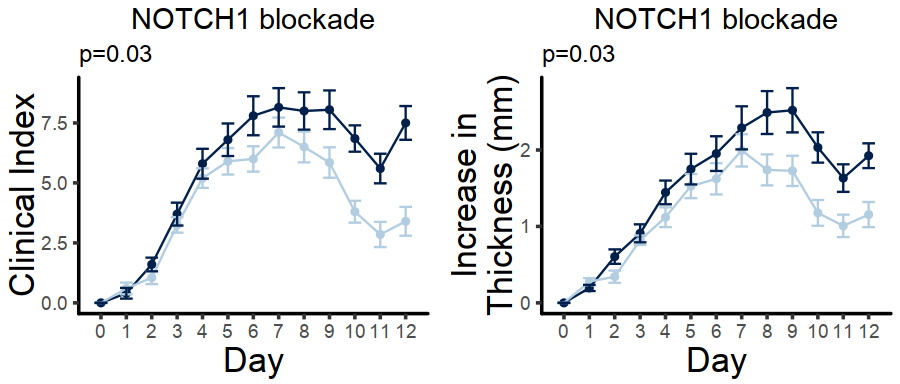

In [268]:
options(repr.plot.height = 3.2, repr.plot.width = 7.5)
# type <- "smooth" 
type <- "line"


palette_histology <- c('#011f4b', '#b3cde0', '#8d5524', '#ffdbac')


(plt <- do_lineplot(plt_df1, "Day", 
            "Clinical Index", palette_histology[1:2], type, 
            c(2, 9), no_bottom = FALSE) +
    labs(title = "NOTCH1 blockade", y = 'Clinical Index', x = 'Day') +
do_lineplot(plt_df2, "Day", 
# do_lineplot("N3KO vs WT arthritis joint thickness.txt", "Day", 
            "Increase in Joint\nThickness (mm)", palette_histology[1:2], type, 
            c(2, 2)) +
    labs(title = "NOTCH1 blockade", y = 'Increase in\nThickness (mm)', x = 'Day') + 
patchwork::plot_layout(byrow = FALSE, nrow = 1)
)

ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/mouse_clinical_notch1.pdf', plot = plt, device = "pdf", 
       dpi = 300, width = 7.5, height = 3.2, useDingbats = FALSE)  


## 17c

In [290]:
library(patchwork)
library(ggthemes)

plotFeatures <- function(data_mat, dim_df, features, nrow = 1, w = 6, h = 4,
                         qlo = 0.05, qhi = 1, order_by_expression = FALSE, 
                         pt_shape = 16, pt_size = .5, no_guide = FALSE,
                         .xlim = c(NA, NA), .ylim = c(NA, NA), color_high = muted('blue')) {
    plt_df <- data.frame(dim_df[, 1:2])
    colnames(plt_df) <- c("X1", "X2")


    plt_list <- lapply(features, function(feature) {
        .x <- setupVals(data_mat, feature, qlo, qhi)
        plt_df$value <- 0
        plt_df[.x@j + 1, "value"] <- .x@x
        if (order_by_expression) {
            plt_df %<>% dplyr::arrange(value)             
        } else {
            plt_df %<>% dplyr::sample_frac(1L)
        }

        plt <- plt_df %>% 
            ggplot(aes(X1, X2, color = value)) + 
            geom_point_rast(dpi = 300, width = w, height = h, size = 1, shape = pt_shape) + 
#             geom_point(shape = ".") + 
            scale_color_gradient2(na.value = "lightgrey", mid = "lightgrey", midpoint = 0, high = color_high) + 
            theme_tufte(base_size = 14, base_family = "Helvetica") + 
            theme(panel.background = element_rect(), plot.title = element_text(hjust = .5)) +
            labs(x = "UMAP 1", y = "UMAP 2", title = feature) + 
            NULL
        if (no_guide) {
            plt <- plt + 
            guides(color = FALSE) 
        }
        
        if (sum(is.na(.xlim)) < 2) 
            plt <- plt + xlim(.xlim)
        if (sum(is.na(.ylim)) < 2) 
            plt <- plt + ylim(.ylim)
        plt

    })
    if (length(plt_list) > 1) {
        Reduce(`+`, plt_list) + patchwork::plot_layout(nrow = nrow)
    } else {
        plt_list[[1]]
    }
}


In [296]:
# features <- paste0('Notch', 1:4)
features <- c('NOTCH1')

fig.size(2.5, 3.5)
with(tissue, {
    plt <- plotFeatures(exprs_norm, umap_harmony, order_by_expression = TRUE, no_guide = TRUE, w = 4 * 1, h = 3 * 1,
                 features, nrow = 1, qlo = 0, qhi = 1, pt_shape = 16, color_high = 'red')
    ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/human_notch1_scatter.pdf', plot = plt, device = "pdf", 
           dpi = 300, width = 3.5, height = 2.5, useDingbats = FALSE)  
})




## 17d

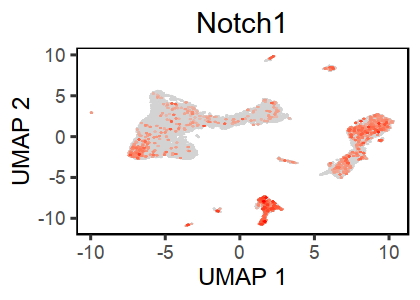

In [230]:
# features <- paste0('Notch', 1:4)
features <- c('Notch1')

fig.size(2.5, 3.5)
with(mouse, {
    plotFeatures(exprs_norm, umap_harmony, order_by_expression = TRUE, no_guide = TRUE, w = 4 * 1, h = 3 * 1,
                 features, nrow = 2, qlo = 0, qhi = 1, pt_shape = 16, color_high = 'red')
})


ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/mouse_notch1_scatter.pdf', device = "pdf", 
       dpi = 300, width = 3.5, height = 2.5, useDingbats = FALSE)  


# Figure 18

Differential expression

In [137]:
idx_use <- which(tissue$meta_data$cell_type %in% c('lining', 'sublining'))
y <- factor(paste(tissue$meta_data$donor[idx_use], tissue$meta_data$cell_type[idx_use], sep = '_'))

In [139]:
## sum over donor
exprs_pseudobulk <- presto::sumGroups(tissue$exprs_norm[, idx_use], as.integer(y), 1) %>% t 
## normalize to get means
exprs_pseudobulk <- exprs_pseudobulk %*% diag(1 / table(y))
row.names(exprs_pseudobulk) <- row.names(tissue$exprs_norm)
colnames(exprs_pseudobulk) <- levels(y)

In [151]:
design <- model.matrix(~cell_type, data.table(cell_type = gsub('(.*)_(.*)', '\\2', levels(y))))
dge_fibro <- exprs_pseudobulk %>% 
    limma::lmFit(design) %>% 
    limma::eBayes() %>% 
    limma::topTable(coef = 2, number = 3e4) %>%
    tibble::rownames_to_column('symbol')


Warning message:
“Zero sample variances detected, have been offset away from zero”

Enrich with GO terms


In [238]:
genes_sublining <- dge_fibro %>% 
    subset(adj.P.Val < .2 & logFC > .2) %>% 
    subset(!grepl('^RPL|^RPS', symbol)) %>% 
    with(symbol)

length(genes_sublining)

[1] 161

In [239]:
library(enrichR)
go_res <- enrichR::enrichr(genes_sublining, c('GO_Biological_Process_2018', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018', 'KEGG_2019_Human'))

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying GO_Cellular_Component_2018... Done.
  Querying GO_Molecular_Function_2018... Done.
  Querying KEGG_2019_Human... Done.
Parsing results... Done.


In [241]:
go_res$GO_Biological_Process_2018 %>% 
    fwrite('/data/srlab/ik936/NOTCH/paper/sublining_pathways.csv', sep = ',')

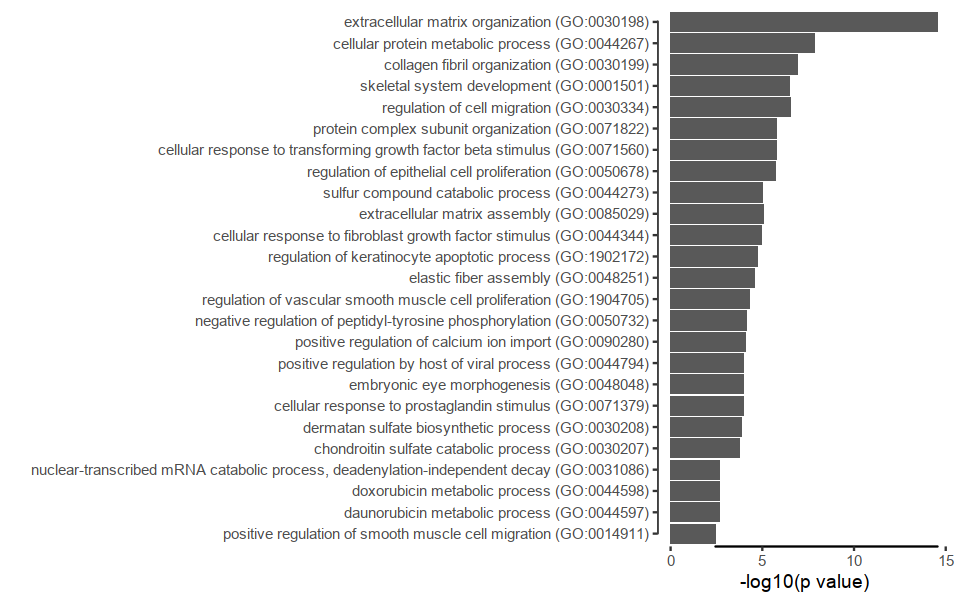

In [291]:
fig.size(5, 8)
go_res$GO_Biological_Process_2018 %>% 
    head(25) %>% 
    ggplot(aes(reorder(Term, -Adjusted.P.value), -log10(P.value))) + 
        geom_bar(stat = 'identity') + 
        coord_flip() + 
        labs(x = '', y = '-log10(p value)') + 
        theme_tufte() + geom_rangeframe() + 
        NULL

ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/pathway_enrichment.pdf', device = "pdf", 
       dpi = 300, width = 8, height = 5, useDingbats = FALSE)